# Face Mask Detection Project

## Import Libraries

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

## Organize Data
Organize data into train, valid, and test directories by moving 500 images of each class to train, 100 images of each class to valid, and 50 images of each class to the test directory.

In [2]:
os.chdir('data')
if os.path.isdir('train') is False:
    os.makedirs('train/with_mask')
    os.makedirs('train/without_mask')
    os.makedirs('valid/with_mask')
    os.makedirs('valid/without_mask')
    os.makedirs('test/with_mask')
    os.makedirs('test/without_mask')

    for i in random.sample(glob.glob('with_mask/*'), 500):
        shutil.move(i, 'train/with_mask')      
    for i in random.sample(glob.glob('without_mask/*'), 500):
        shutil.move(i, 'train/without_mask')
    for i in random.sample(glob.glob('with_mask/*'), 100):
        shutil.move(i, 'valid/with_mask')        
    for i in random.sample(glob.glob('without_mask/*'), 100):
        shutil.move(i, 'valid/without_mask')
    for i in random.sample(glob.glob('with_mask/*'), 50):
        shutil.move(i, 'test/with_mask')      
    for i in random.sample(glob.glob('without_mask/*'), 50):
        shutil.move(i, 'test/without_mask')

os.chdir('../')

## Prepare Image
Use Keras ImageDataGenerator to create batches of data from the train, valid, and test directories and preprocessing image for using with VGG16 model.

In [3]:
train_path = 'data/train'
valid_path = 'data/valid'
test_path = 'data/test'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['with_mask', 'without_mask'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['with_mask', 'without_mask'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['with_mask', 'without_mask'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
imgs, labels = next(train_batches)

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..131.32].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-115.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-112.68..139.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..140.061].
Clipping input data t

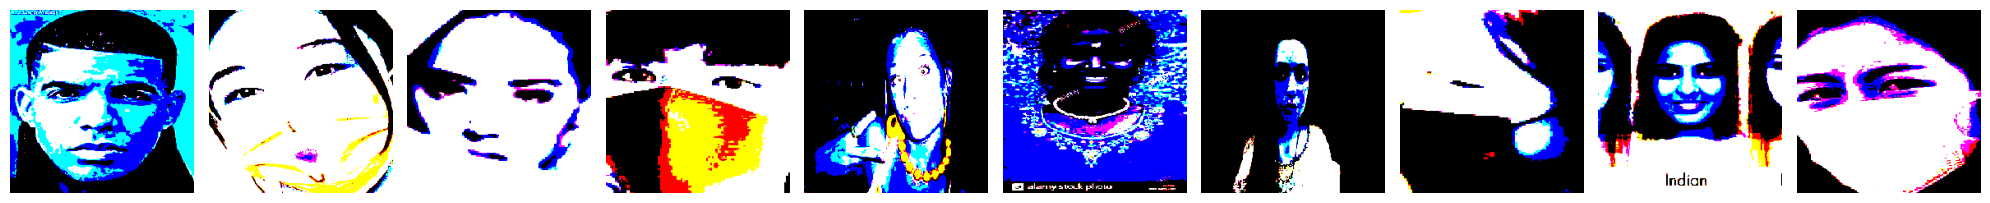

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [7]:
plotImages(imgs)
print(labels)

## Build a fine-tuned neural network with VGG16 model
Import the VGG16 model from Keras and fine-tune it to work with our 2 classes output (with_mask and without_mask).

In [8]:
vgg16_model = tf.keras.applications.vgg16.VGG16()

In [9]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model = Sequential()

In [11]:
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [12]:
for layer in model.layers:
    layer.trainable = False

In [13]:
model.add(Dense(units = 2, activation = 'softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

## Train a Fine-Tuned Model

In [15]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
history = model.fit(x = train_batches,
                    steps_per_epoch = len(train_batches),
                    validation_data = valid_batches,
                    validation_steps = len(valid_batches),
                    epochs = 5,
                    verbose = 2
                   )

Epoch 1/5
100/100 - 24s - loss: 0.3401 - accuracy: 0.8560 - val_loss: 0.1619 - val_accuracy: 0.9450 - 24s/epoch - 237ms/step
Epoch 2/5
100/100 - 14s - loss: 0.0981 - accuracy: 0.9680 - val_loss: 0.1058 - val_accuracy: 0.9750 - 14s/epoch - 141ms/step
Epoch 3/5
100/100 - 14s - loss: 0.0599 - accuracy: 0.9820 - val_loss: 0.0844 - val_accuracy: 0.9800 - 14s/epoch - 139ms/step
Epoch 4/5
100/100 - 14s - loss: 0.0415 - accuracy: 0.9900 - val_loss: 0.0744 - val_accuracy: 0.9850 - 14s/epoch - 139ms/step
Epoch 5/5
100/100 - 14s - loss: 0.0313 - accuracy: 0.9940 - val_loss: 0.0681 - val_accuracy: 0.9850 - 14s/epoch - 140ms/step


In [17]:
model_loss = pd.DataFrame(model.history.history)

In [18]:
model_loss

,loss,accuracy,val_loss,val_accuracy
0,0.340090,0.856,0.161892,0.945
1,0.098142,0.968,0.105772,0.975
2,0.059868,0.982,0.084357,0.980
3,0.041464,0.990,0.074438,0.985
4,0.031344,0.994,0.068073,0.985


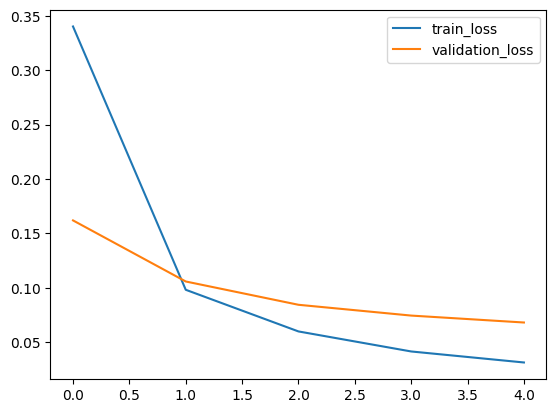

In [19]:
plt.plot(model_loss['loss'],label = 'train_loss')
plt.plot(model_loss['val_loss'],label = 'validation_loss')
plt.legend()
plt.show()

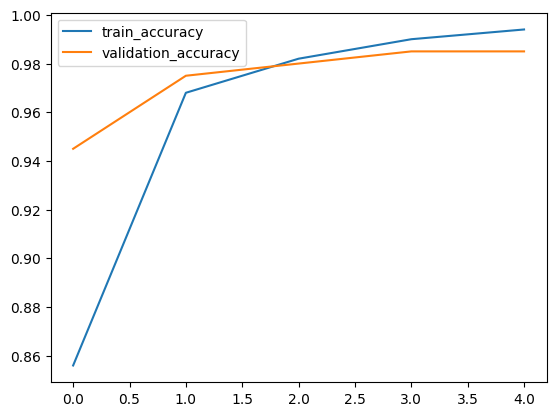

In [20]:
plt.plot(model_loss['accuracy'],label = 'train_accuracy')
plt.plot(model_loss['val_accuracy'],label = 'validation_accuracy')
plt.legend()
plt.show()

## Predict with Fine-Tuned Model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..147.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-100.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-117.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..138.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data

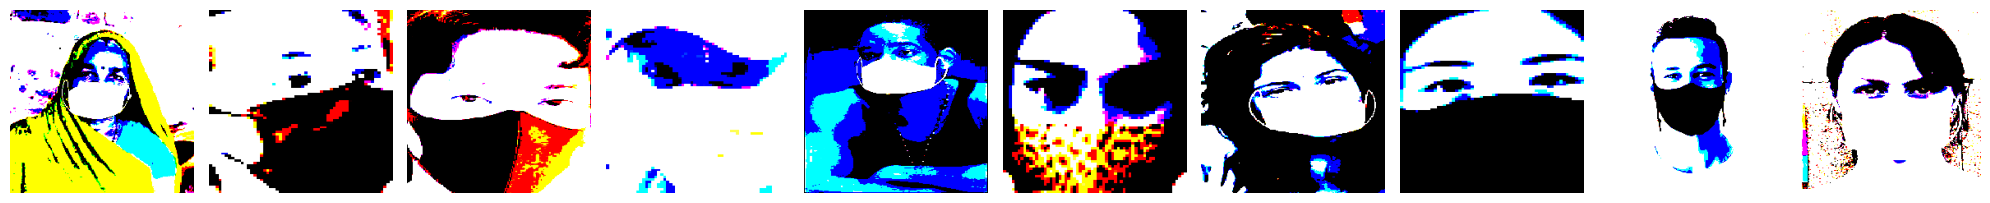

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [21]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [22]:
predictions = model.predict(x = test_batches, steps = len(test_batches), verbose = 1)

10/10 [==============================] - 1s 117ms/step


## Model Evaluation

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [24]:
test_batches.class_indices

{'with_mask': 0, 'without_mask': 1}

In [25]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))

Confusion matrix, without normalization
[[50  0]
 [ 0 50]]


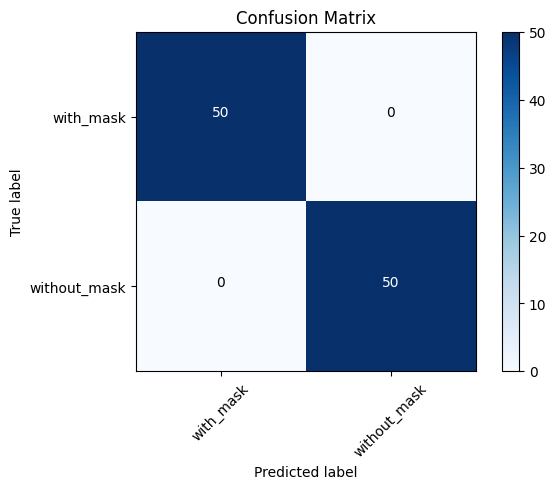

In [26]:
plot_labels = ['with_mask','without_mask']
plot_confusion_matrix(cm = cm, classes = plot_labels, title = 'Confusion Matrix')

In [27]:
print(classification_report(test_batches.classes,np.argmax(predictions, axis = -1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



## Display test image and predictions

In [28]:
def plot_images(test_imgs, test_labels, random_indices, model, plot_labels):
    img_rows=2
    img_cols=5
    _, axs = plt.subplots(img_rows, img_cols, figsize=(32, 8))
    axs = axs.flatten()

    for i, idx in enumerate(random_indices):
        img = test_imgs[idx]  
        label = test_labels[idx] 

        # Reverse the VGG16 preprocessing to orginal images 
        img_output = img + np.array([123.68, 116.779, 103.939])  
        img_output = np.clip(img_output, 0, 255).astype('uint8') 
        img_output = cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)

        axs[i].imshow(img_output)
        axs[i].axis('off')

        img_for_prediction = np.expand_dims(test_imgs[idx], axis=0)  # Add batch dimension for model input
        prediction = model.predict(img_for_prediction)  # Get model prediction

        lab = np.argmax(label)
        pred = np.argmax(prediction)

        true_label_name = plot_labels[lab]
        pred_label_name = plot_labels[pred]

        color = 'green' if lab == pred else 'red'

        axs[i].set_title(f'y: {true_label_name} | y_pred: {pred_label_name}', fontsize=14, color=color)

    plt.show()


1/1 [==============================] - 0s 23ms/step


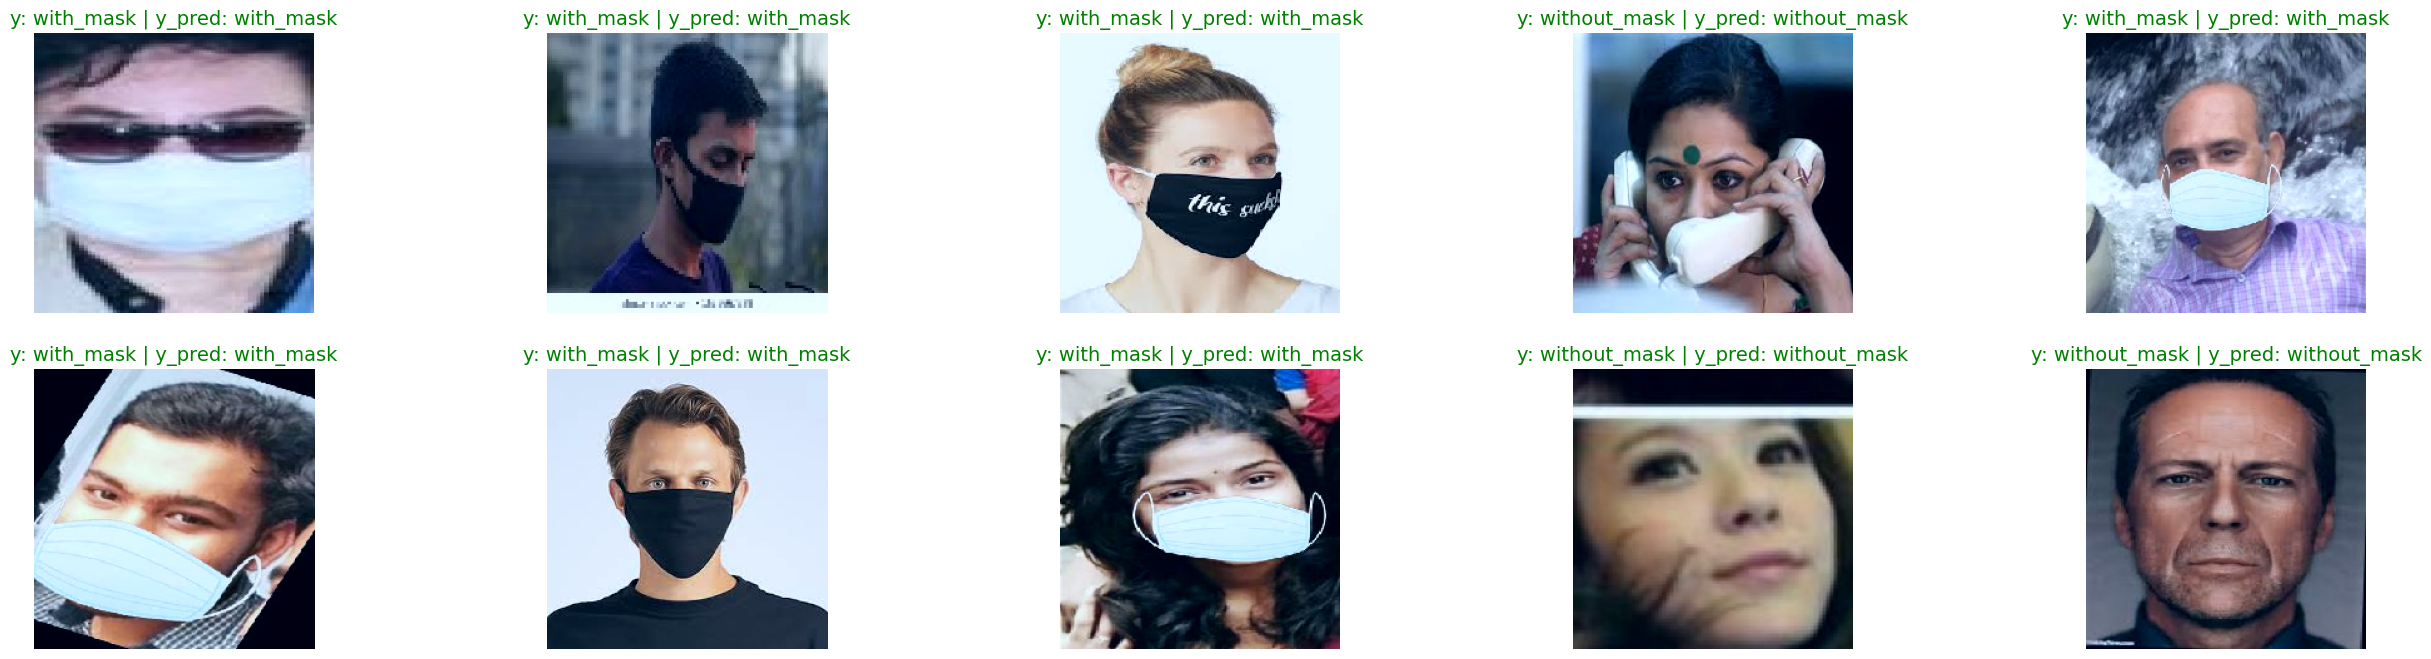

In [32]:
test_imgs = []
test_labels = []

for i in range(len(test_batches)):
    imgs, labels = test_batches[i]
    test_imgs.append(imgs)
    test_labels.append(labels)

test_imgs = np.vstack(test_imgs)
test_labels = np.vstack(test_labels)

# Randomly choose image to display
random_indices = random.sample(range(len(test_imgs)), 10)

plot_labels = ['with_mask', 'without_mask']

plot_images(test_imgs, test_labels, random_indices, model, plot_labels)

## Save model

In [33]:
model.save('my_model.h5')